In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px



from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split



from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier


from matplotlib import ticker
import time
import warnings
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:f}'.format)
warnings.filterwarnings('ignore')


RANDOM_STATE = 12 
FOLDS = 5

# Data Cleaning

In [2]:
df = pd.read_csv('train.csv')
df.drop(['Unnamed: 0','id'],axis=1,inplace=True)

In [3]:
df.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.000000,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.000000,neutral or dissatisfied
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.000000,satisfied
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.000000,neutral or dissatisfied
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.000000,satisfied


### Formatting

In [4]:
df.rename({'satisfaction':'Satisfaction'},axis=1,inplace=True)
df['Satisfaction'] = np.where(df['Satisfaction']=='satisfied',1,0)

To achieve consistent formatting for all columns, the "satisfaction" column can be renamed with the first letter capitalized. Additionally, the values in the "satisfied" column can be converted, where "satisfied" is assigned a value of 1, and "neutral or dissatisfied" are assigned a value of 0.

In [5]:
target = 'Satisfaction'
features = [col for col in df.columns if col not in [target]]
cat_features = [col for col in features if df[col].nunique() < 25]
cont_features = [col for col in features if df[col].nunique() >= 25]

### Create New Feature

In [6]:
df['Seat comfort high rating'] = np.where(df['Seat comfort']>3,1,0)
df['Inflight entertainment high rating'] = np.where(df['Inflight entertainment']>3,1,0)
df['On-board service high rating'] = np.where(df['On-board service']>3,1,0)
df['Leg room high rating'] = np.where(df['Leg room service']>3,1,0)

features.append('Seat comfort high rating')
features.append('Inflight entertainment high rating')
features.append('On-board service high rating')
features.append('Leg room high rating')

I have observed a strong trend in the in-flight ratings, where higher ratings correspond to higher averages of the target variable. Therefore, I would like to create a new feature indicating high ratings. This feature will have a value of 1 if the rating is 4 or 5, and 0 otherwise.

### Splitting the Dataset

In [7]:
X = df[features]
y = df[target]

In [8]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X_fulltrain, X_test, y_fulltrain, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_fulltrain, y_fulltrain, test_size=0.2, random_state=42)

# Print the shapes of the resulting datasets
print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)


Train set shape: (66498, 26) (66498,)
Validation set shape: (16625, 26) (16625,)
Test set shape: (20781, 26) (20781,)


We will split the dataset into train, val, and test sets. The train set will be used for training the model, the val set will be used for tuning hyperparameters, and the test set will be used for the final evaluation and metrics.

### Handling Missing Values

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 27 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Gender                              103904 non-null  object 
 1   Customer Type                       103904 non-null  object 
 2   Age                                 103904 non-null  int64  
 3   Type of Travel                      103904 non-null  object 
 4   Class                               103904 non-null  object 
 5   Flight Distance                     103904 non-null  int64  
 6   Inflight wifi service               103904 non-null  int64  
 7   Departure/Arrival time convenient   103904 non-null  int64  
 8   Ease of Online booking              103904 non-null  int64  
 9   Gate location                       103904 non-null  int64  
 10  Food and drink                      103904 non-null  int64  
 11  Online boarding           

In [10]:
print('Mean  : ',X_train['Arrival Delay in Minutes'].mean())
print('Median: ',X_train['Arrival Delay in Minutes'].median())

Mean  :  15.173036894023953
Median:  0.0


In [11]:
print('Number of row with 0 values    : ',len(X_train[X_train['Arrival Delay in Minutes']==0]))
print('Number of row with non 0 values: ',len(X_train[X_train['Arrival Delay in Minutes']!=0]))

Number of row with 0 values    :  37300
Number of row with non 0 values:  29198


We observed that the "Arrival Delay in Minutes" feature exhibits an extreme right-skewed distribution. Additionally, there is a higher frequency of 0 minute delay occurrences. Based on this, I have decided to impute the missing values in this feature with the median value.

In [12]:
# Impute the data with median
median = X_train['Arrival Delay in Minutes'].median()
X_train = X_train.fillna(median)
X_val = X_val.fillna(median)
X_test = X_test.fillna(median)

### Transform the Data

Some Algorithm like Logistic Regression or Gaussian Naive Bayes assume the data is normal distribution. We need to apply transformation for the skewed data that we have. Also by making it normal distribution, we also can reduce the outlier that we have. This will also help for model like K-Nearest Neighbors and Support Vector Machines. 

We wil apply the transformation by experimenting using various technique like log or root square until it get better distribution.

<Axes: xlabel='Flight Distance', ylabel='Count'>

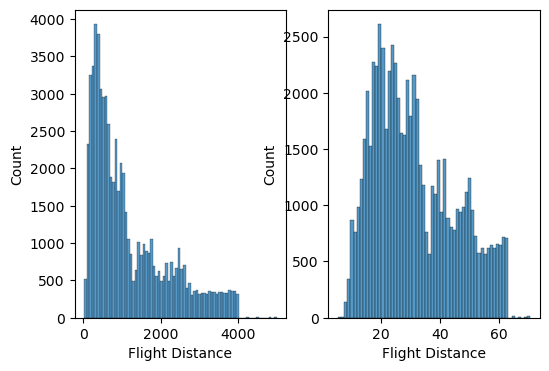

In [13]:
# Set up the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 4))

# Create distribution plots using Seaborn
sns.histplot(data=X_train['Flight Distance'], ax=axes[0])
sns.histplot(data=X_train['Flight Distance']**0.5, ax=axes[1])

<Axes: xlabel='Departure Delay in Minutes', ylabel='Count'>

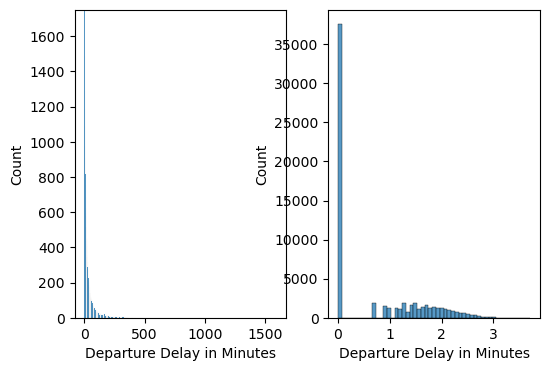

In [14]:
# Set up the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 4))

# Create distribution plots using Seaborn
sns.histplot(data=X_train['Departure Delay in Minutes'], ax=axes[0])
axes[0].set_ylim(0, 1750)
sns.histplot(data=np.log1p(X_train['Departure Delay in Minutes']**0.5), ax=axes[1])

<Axes: xlabel='Arrival Delay in Minutes', ylabel='Count'>

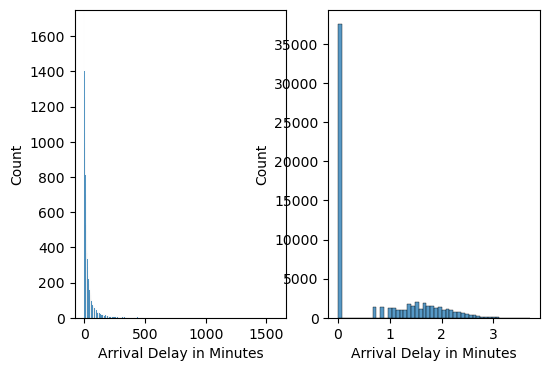

In [15]:
# Set up the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 4))

# Create distribution plots using Seaborn
sns.histplot(data=X_train['Arrival Delay in Minutes'], ax=axes[0])
axes[0].set_ylim(0, 1750)
sns.histplot(data=np.log1p(X_train['Arrival Delay in Minutes']**0.5), ax=axes[1])

In [16]:
# Apply the transformation
X_train['Flight Distance'] = X_train['Flight Distance']**0.5
X_val['Flight Distance'] = X_val['Flight Distance']**0.5
X_test['Flight Distance'] = X_test['Flight Distance']**0.5

X_train['Departure Delay in Minutes'] = np.log1p(X_train['Departure Delay in Minutes']**0.5)
X_val['Departure Delay in Minutes'] = np.log1p(X_val['Departure Delay in Minutes']**0.5)
X_test['Departure Delay in Minutes'] = np.log1p(X_test['Departure Delay in Minutes']**0.5)

X_train['Arrival Delay in Minutes'] = np.log1p(X_train['Arrival Delay in Minutes']**0.5)
X_val['Arrival Delay in Minutes'] = np.log1p(X_val['Arrival Delay in Minutes']**0.5)
X_test['Arrival Delay in Minutes'] = np.log1p(X_test['Arrival Delay in Minutes']**0.5)

### Scaling

In [17]:
from sklearn.preprocessing import StandardScaler

# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit the scaler to the data and transform it
X_train_scaled = scaler.fit_transform(X_train[cont_features])
X_val_scaled = scaler.transform(X_val[cont_features])
X_test_scaled = scaler.transform(X_test[cont_features])

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=cont_features).reset_index(drop=True)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=cont_features).reset_index(drop=True)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=cont_features).reset_index(drop=True)

We will scale the continuous features so that they have a similar scale or range. This is beneficial for models that use distance-based algorithms like KNN or SVM, as well as models that utilize gradient descent. 

### Encode

In [18]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Create an instance of OneHotEncoder
onehotencoder = OneHotEncoder(drop='first')

# Fit the encoder to the data and transform it
ohe_features = ['Gender', 'Customer Type', 'Type of Travel']
X_train_ohe = onehotencoder.fit_transform(X_train[ohe_features])
X_val_ohe = onehotencoder.transform(X_val[ohe_features])
X_test_ohe = onehotencoder.transform(X_test[ohe_features])

# Convert back to DataFrame
X_train_ohe = pd.DataFrame(X_train_ohe.toarray(), columns=onehotencoder.get_feature_names_out())
X_val_ohe = pd.DataFrame(X_val_ohe.toarray(), columns=onehotencoder.get_feature_names_out())
X_test_ohe = pd.DataFrame(X_test_ohe.toarray(), columns=onehotencoder.get_feature_names_out())

In [19]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Create an instance of OneHotEncoder
onehotencoder = OneHotEncoder(drop='first')

# Fit the encoder to the data and transform it
ohe_features = [ 'Customer Type', 'Type of Travel']
X_train_oh = onehotencoder.fit_transform(X_train[ohe_features])

# Convert back to DataFrame
X_train_oh = pd.DataFrame(X_train_oh.toarray(), columns=onehotencoder.get_feature_names_out())


We will apply One Hot Encoding to the Gender, Customer Type, and Type of Travel features since each of them has only two unique values. By doing so, we can convert these categorical features into binary representations, specifically 0s and 1s.

In [21]:
# Create an instance of LabelEncoder
labelencoder = LabelEncoder()

# Fit the encoder to the data and transform it
X_train_le = labelencoder.fit_transform(X_train['Class'])
X_val_le = labelencoder.fit_transform(X_val['Class'])
X_test_le = labelencoder.fit_transform(X_test['Class'])

# Convert back to DataFrame
X_train_le = pd.DataFrame(X_train_le, columns=['Class'])
X_val_le = pd.DataFrame(X_val_le, columns=['Class'])
X_test_le = pd.DataFrame(X_test_le, columns=['Class'])

In [22]:
import pickle

# Save OneHotEncoder
with open("onehotencoder.pkl", "wb") as f:
    pickle.dump(onehotencoder, f)

# Save LabelEncoder
with open("labelencoder.pkl", "wb") as f:
    pickle.dump(labelencoder, f)

# Save StandardScaler
with open("standardscaler.pkl", "wb") as f:
    pickle.dump(scaler, f)



In the Class feature, there are three unique values. Since these values follow a logical order, we will use LabelEncoder instead of One Hot Encoder.

In [23]:
# Feature that is not scaled or encoded
f=[ 'Inflight wifi service',
 'Departure/Arrival time convenient',
 'Ease of Online booking',
 'Gate location',
 'Food and drink',
 'Online boarding',
 'Seat comfort',
 'Inflight entertainment',
 'On-board service',
 'Leg room service',
 'Baggage handling',
 'Checkin service',
 'Inflight service',
 'Cleanliness',
 'Seat comfort high rating',
 'Inflight entertainment high rating',
 'On-board service high rating',
 'Leg room high rating']

X_tr = X_train[f].reset_index(drop=True)
X_v = X_val[f].reset_index(drop=True)
X_te = X_test[f].reset_index(drop=True)

In [24]:
# Concate back
X_train_cleaned = pd.concat([X_train_scaled,X_train_ohe,X_train_le,X_tr],axis=1)
X_val_cleaned = pd.concat([X_val_scaled,X_val_ohe,X_val_le,X_v],axis=1)
X_test_cleaned = pd.concat([X_test_scaled,X_test_ohe,X_test_le,X_te],axis=1)

### Feature Selection

In [25]:
print("Number of Columns: ",len(X_train_cleaned.columns))

Number of Columns:  26


We have 29 features, which is a lot. To improve the model's performance and remove irrelevant or redundant features, we will perform feature selection. By reducing the number of features, we can enhance the model's efficiency and speed up the training and prediction processes. For this purpose, we will use Lasso regression, which helps identify and select the most important features. This way, we can optimize the model's performance while maintaining interpretability.

In [26]:
X_test_cleaned

,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Male,Customer Type_disloyal Customer,Type of Travel_Personal Travel,Class,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Seat comfort high rating,Inflight entertainment high rating,On-board service high rating,Leg room high rating
0,-0.879022,-0.158438,-0.805981,-0.811688,0.000000,0.000000,1.000000,1,2,4,2,5,5,2,5,5,5,4,4,3,5,5,1,1,1,1
1,-1.143269,-0.844702,-0.805981,1.015212,1.000000,0.000000,0.000000,0,3,5,5,5,3,3,3,3,1,1,3,2,3,3,0,0,0,0
2,1.301009,-1.264613,1.429946,1.369399,0.000000,0.000000,1.000000,1,1,3,1,3,2,3,3,4,4,1,4,3,4,4,0,1,1,0
3,-0.482653,0.028628,1.277201,0.435366,0.000000,0.000000,1.000000,1,2,3,2,4,4,2,4,4,3,2,4,1,4,4,1,1,0,0
4,-0.284469,0.135628,-0.805981,-0.811688,1.000000,1.000000,0.000000,0,2,2,2,1,2,2,5,2,2,2,3,2,2,2,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20776,0.177962,-1.166395,-0.805981,-0.811688,1.000000,1.000000,0.000000,0,1,1,1,3,1,1,1,1,2,3,4,2,4,1,0,0,0,0
20777,-1.671761,-0.570891,-0.805981,-0.811688,1.000000,0.000000,1.000000,1,2,4,2,2,5,2,5,5,4,4,5,5,4,5,1,1,1,1
20778,-2.002069,0.011634,-0.014310,-0.811688,1.000000,0.000000,1.000000,1,2,5,2,3,5,2,5,5,4,4,2,3,5,5,1,1,1,1
20779,0.376147,1.826073,-0.805981,1.093899,0.000000,0.000000,0.000000,0,3,3,3,3,5,5,5,4,4,4,4,3,4,3,1,1,1,1


In [27]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split


# Create a Lasso regression object
lasso = Lasso()

# Define the parameter grid for alpha values
param_grid = {'alpha': np.arange(0.01,1,0.05)}

# Create a GridSearchCV object
grid_search = GridSearchCV(lasso, param_grid, cv=5)

# Fit the GridSearchCV object on the training data
grid_search.fit(X_train_cleaned, y_train)

# Retrieve the best alpha value and corresponding model
best_alpha = grid_search.best_params_['alpha']
best_model = grid_search.best_estimator_

# Fit the Lasso regression model again with the best alpha
best_model.fit(X_train_cleaned, y_train)

# Retrieve the selected feature
coefficients = grid_search.best_estimator_.coef_
selected_feature = np.array(X_train_cleaned.columns)[coefficients!=0]

# Evaluate the performance on the testing set
#score = best_model.score(X_test, y_test)

print("Best alpha:", best_alpha)
print("Number of selected feature:", len(selected_feature))
print("Selected feature:", (selected_feature))

Best alpha: 0.01
Number of selected feature: 19
Selected feature: ['Flight Distance' 'Arrival Delay in Minutes'
 'Customer Type_disloyal Customer' 'Type of Travel_Personal Travel'
 'Class' 'Inflight wifi service' 'Departure/Arrival time convenient'
 'Ease of Online booking' 'Online boarding' 'Inflight entertainment'
 'On-board service' 'Leg room service' 'Baggage handling'
 'Checkin service' 'Inflight service' 'Cleanliness'
 'Seat comfort high rating' 'Inflight entertainment high rating'
 'Leg room high rating']


Out of the original 26 features, the feature selection using Lasso regression resulted in only 19 features remaining.

Now, we will compare the performance of the model using the original dataset with all 26 features and the reduced dataset with only the selected 19 features. This will help us assess whether the feature selection process has improved the model's performance or not.

# Modeling

#### Compare the Model

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier to the training data
rf_classifier.fit(X_train_cleaned, y_train)

# Predict on the validation data
y_pred = rf_classifier.predict(X_val_cleaned)

# Calculate the accuracy score
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9624060150375939


In [29]:
# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier to the training data
rf_classifier.fit(X_train_cleaned[selected_feature], y_train)

# Predict on the validation data
y_pred = rf_classifier.predict(X_val_cleaned[selected_feature])

# Calculate the accuracy score
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9595789473684211


There is a difference of only 0.003 in terms of accuracy, so I believe the feature selection has performed well. This minimal difference suggests that the selected features are valuable in improving the model's predictive capabilities. Feature selection can effectively enhance model efficiency, reduce overfitting, and focus on the most relevant features. Now we will compare the model like Logistic Regression, KNN, Catboost, LightGBM, and XGBoost.

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Create a dictionary to store the models
models = {
    "Lasso Regression": LogisticRegression(penalty='l2'),
    "KNN": KNeighborsClassifier(),
    "CatBoost": CatBoostClassifier(verbose=False),
    "LightGBM": LGBMClassifier(),
    "XGBoost": XGBClassifier()
}

# Train and evaluate each model
for model_name, model in models.items():
    # Fit the model to the training data
    model.fit(X_train_cleaned[selected_feature], y_train)
    
    # Predict on the validation data
    y_pred = model.predict(X_val_cleaned[selected_feature])
    
    # Calculate the accuracy score
    accuracy = accuracy_score(y_val, y_pred)
    
    print(f"{model_name} Accuracy: {accuracy}")


Lasso Regression Accuracy: 0.882827067669173
KNN Accuracy: 0.9303458646616541
CatBoost Accuracy: 0.9613834586466166
LightGBM Accuracy: 0.960421052631579
XGBoost Accuracy: 0.958796992481203


We can see that Catboost have the highest accuracy, we will try to hyperparameter tuning the model below using RandomSearchCV. We use RandomSearch instead of GridSearch to get the faster time tuning.

### Hyperparameter Catboost

In [31]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Define the CatBoost classifier
model = CatBoostClassifier(verbose=False)

# Define the hyperparameter grid
param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': uniform(0.01, 0.2),
    'depth': [4, 6, 8],
    'l2_leaf_reg': uniform(1, 10)
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42)

# Fit the model using RandomizedSearchCV
random_search.fit(X_train_cleaned[selected_feature], y_train)

# Print the best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)


Best Parameters: {'depth': 8, 'iterations': 200, 'l2_leaf_reg': 1.906064345328208, 'learning_rate': 0.13367720186661747}
Best Score: 0.9587807314360794


# Evaluation

In [32]:
random_search.best_estimator_.save_model("model.cb")

In [33]:
y_pred = random_search.best_estimator_.predict(X_val_cleaned[selected_feature])
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9604812030075188


In [34]:
y_pred = random_search.best_estimator_.predict(X_test_cleaned[selected_feature])
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9601077907704153



After tuning the model, we obtained similar accuracies for both the validation set and the test set. This is a positive indication as it suggests that we are not overfitting the model. Moreover, the model demonstrates the ability to make accurate predictions on unseen data.

### Feature Importance

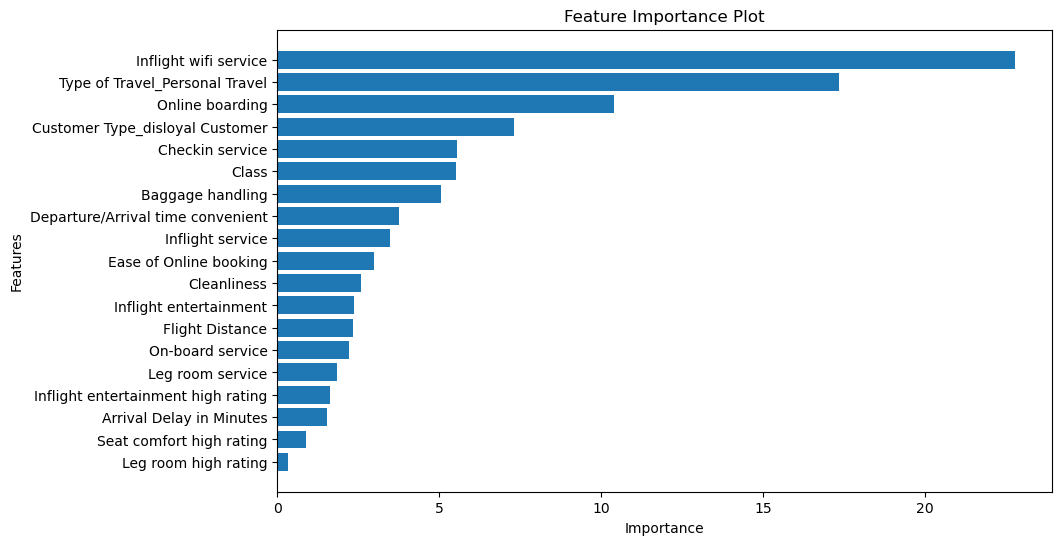

In [35]:
import matplotlib.pyplot as plt

# Get feature importances from the best estimator
feature_importances = random_search.best_estimator_.feature_importances_

# Get the indices that would sort the feature importances array in descending order
sorted_indices = feature_importances.argsort()[::-1]

# Sort the feature importances and selected feature names accordingly
sorted_feature_importances = feature_importances[sorted_indices]
sorted_selected_feature = [selected_feature[i] for i in sorted_indices]

# Create a horizontal bar plot of sorted feature importances with longest bar on top
plt.figure(figsize=(10, 6))
plt.barh(sorted_selected_feature, sorted_feature_importances, align='center')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance Plot")
plt.gca().invert_yaxis()  # Invert the y-axis to show the longest bar on top
plt.show()


We can observe that the top three most important features are Inflight WiFi Service, Type of Travel (Personal Travel), and Online Boarding. However, unfortunately, the features we created earlier, such as Seat Comfort High Rating, Leg Room High Rating, and Arrival Delay in Minutes, belong to the three least important features

### Cross Validation

In [36]:
X_cleaned = pd.concat([X_train_cleaned,X_val_cleaned,X_test_cleaned])[selected_feature]
y_cleaned = pd.concat([y_train,y_val,y_test])

In [37]:
from sklearn.model_selection import cross_val_score

# Perform k-fold cross-validation
k = 5  # Number of folds
scores = cross_val_score(random_search.best_estimator_, X_cleaned, y_cleaned, cv=k, scoring='accuracy')

# Calculate the mean accuracy
mean_accuracy = scores.mean()
print(f"Mean Accuracy: {mean_accuracy}")

Mean Accuracy: 0.9606271174171231


To ensure that we do not overfit the model, we will perform cross-validation. Since the dataset is not imbalanced, we will use K-Fold cross-validation. The cross-validation results are still consistent with the previous evaluations, indicating that the model performs well and does not overfit. Overall, the model appears to be in good shape.